In [1]:
import json
import os
import random
import time
import cv2
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as et

import detectron2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

## Dataset 1

In [2]:
DATASET1_CLASS_MAPPING = {
    'face_with_mask': 0,
    'face_no_mask': 1,
    'face_with_mask_incorrect': 1,
    'face_other_covering': 1,
    'mask_surgical': -1,
    'face_shield': -1,
    'hat': -1, 
    'eyeglasses': -1, 
    'mask_colorful': -1,
    'helmet': -1,
    'sunglasses': -1,
    'scarf_bandana': -1,
    'hair_net': -1,
    'goggles': -1,
    'hijab_niqab': -1,
    'turban': -1,
    'balaclava_ski_mask': -1,
    'gas_mask': -1,
    'hood': -1,
    'other': -1}

In [3]:
def get_facemask_1_dicts(dataset_dir, split='train'):
    """
    Return a list of dictionaries containing the dataset's annotations.
    
    Args:
        dataset_dir (str): path to the dataset parent directory
        split (str): get annotations for 'train', 'val', or 'test' split. Default: 'train'
            note: fixed train:val:test split ratio of 0.7:0.15:0.15
    Return:
        dataset_dicts (list): a list of dictionaries
    """
    img_dir = os.path.join(dataset_dir, "images")
    annotation_dir = os.path.join(dataset_dir, "annotations")
    annot_file_path_list = []
    for file in sorted(os.listdir(annotation_dir)):
        annot_file_path_list.append(os.path.join(annotation_dir, file))

    # random shuffle files list
    random.seed(3)
    random.shuffle(annot_file_path_list)
    
    # tain, val, test splits
    num_files = len(annot_file_path_list)
    train_index, val_index = int(num_files * 0.7), int(num_files * 0.85)
    
    train_set = annot_file_path_list[:train_index]
    val_set = annot_file_path_list[train_index:val_index]
    test_set = annot_file_path_list[val_index:]
    
    splits = {
        "train": train_set,
        "val": val_set,
        "test": test_set
    }
    
    dataset_dicts = []
    # loop over all annotation json files
    for idx, file in enumerate(splits.get(split)):
        with open(file) as json_file:
            data = json.load(json_file)  # type: dict
            annotations = data["Annotations"]  # type: list
        
        img_path = os.path.join(img_dir, data["FileName"])
        img = imread(img_path)
        height, width, _ = img.shape
        
        record = {}
        record["file_name"] = img_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        objs = []
        for annot in annotations:
            classname = annot["classname"]
            bbox = np.array(annot["BoundingBox"])
            category_id = DATASET1_CLASS_MAPPING[classname]
            if category_id == -1:
                continue
            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": category_id,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


In [4]:
dataset_dir = "./datasets/dataset1/Medical_mask/Medical_mask/Medical_Mask/"
for d in ["train", "val"]:
    DatasetCatalog.register("facemask_1_" + d, lambda d=d: get_facemask_1_dicts(dataset_dir, d))
    MetadataCatalog.get("facemask_1_" + d).set(thing_classes=['face_with_mask', 'face_no_mask'],
                                              evaluator_type="coco")


In [5]:
facemask_1_metadata = MetadataCatalog.get("facemask_1_train")

72.7474889755249


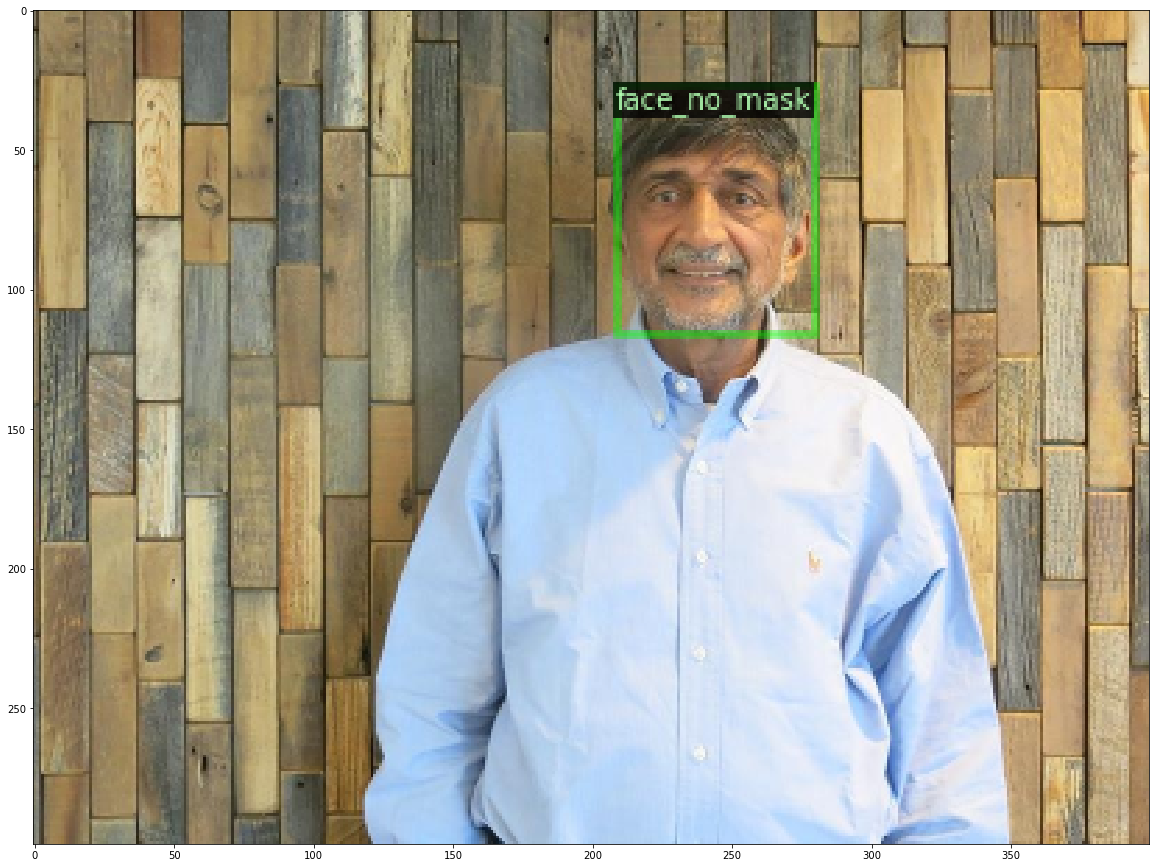

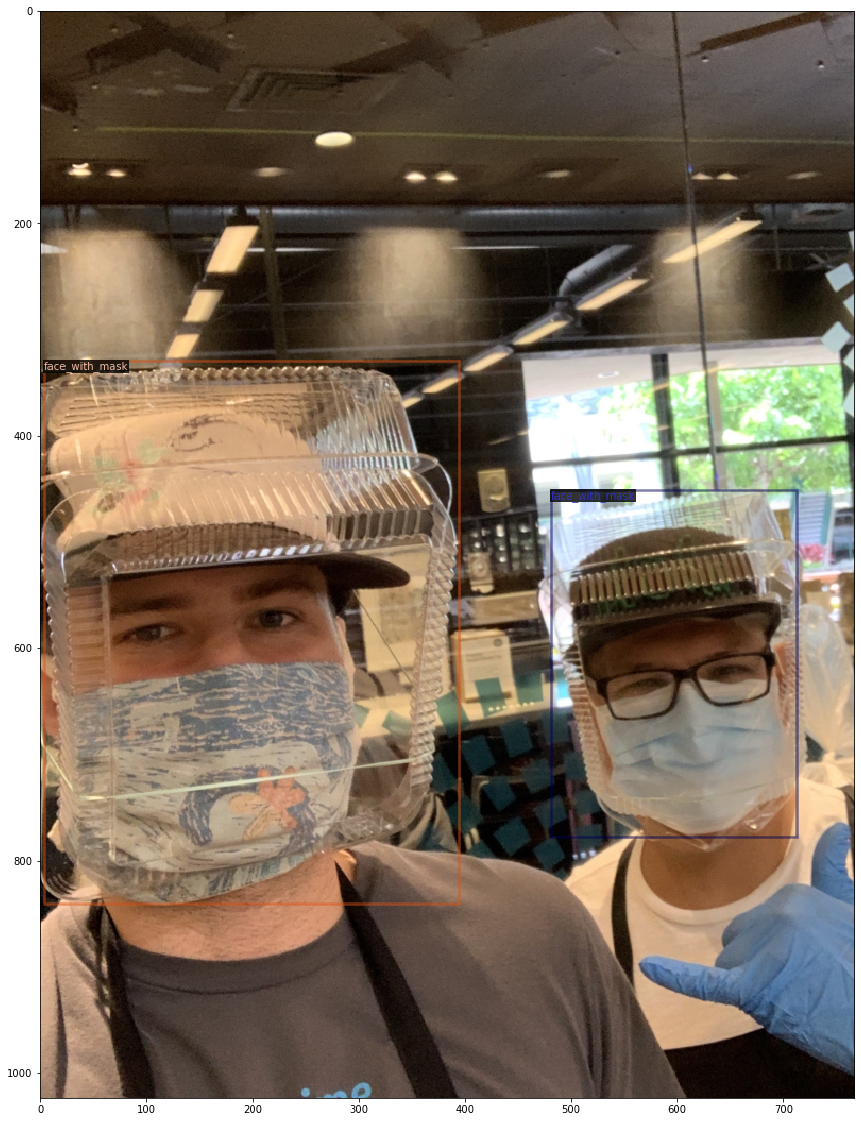

In [6]:
start = time.time()
dataset_dicts = get_facemask_1_dicts(dataset_dir, "train")
print(time.time()-start)
# select two samples to verify the data loading is correct
for d in dataset_dicts[5:7]:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=facemask_1_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(20, 20))
    plt.imshow(out.get_image())
    plt.show()


## Dataset 2

In [2]:
DATASET2_CLASS_MAPPING = {
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 1}

In [3]:
def get_facemask_2_dicts(dataset_dir):
    """
    Return a list of dictionaries containing the dataset2's annotations, 
    used as test set.
    
    Args:
        dataset_dir (str): path to the dataset parent directory

    Return:
        dataset_dicts (list): a list of dictionaries
    """
    img_dir = os.path.join(dataset_dir, "images")
    annotation_dir = os.path.join(dataset_dir, "annotations")
    annot_file_path_list = []
    for file in sorted(os.listdir(annotation_dir)):
        annot_file_path_list.append(os.path.join(annotation_dir, file))

    # random shuffle files list
    random.seed(3)
    random.shuffle(annot_file_path_list)
    
    dataset_dicts = []
    # loop over all annotation xml files
    for idx, file in enumerate(annot_file_path_list):
        xml = et.parse(file)
        root = xml.getroot()
        filename = root[1].text
        annotations = root[4:]
        
        img_path = os.path.join(img_dir, filename)
        img = imread(img_path)
        height, width, _ = img.shape
        
        record = {}
        record["file_name"] = img_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        objs = []
        for annot in annotations:
            classname = annot[0].text
            bbox = np.array([int(v.text) for v in annot[5]])
            category_id = DATASET2_CLASS_MAPPING[classname]
            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": category_id,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


In [4]:
dataset2_dir = "./datasets/dataset2"
for d in ["test"]:
    DatasetCatalog.register("facemask_2_" + d, lambda d=d: get_facemask_2_dicts(dataset2_dir))
    MetadataCatalog.get("facemask_2_" + d).set(thing_classes=['with_mask', 'without_mask'],
                                              evaluator_type="coco")

In [5]:
facemask_2_metadata = MetadataCatalog.get("facemask_2_test")

13.922539949417114


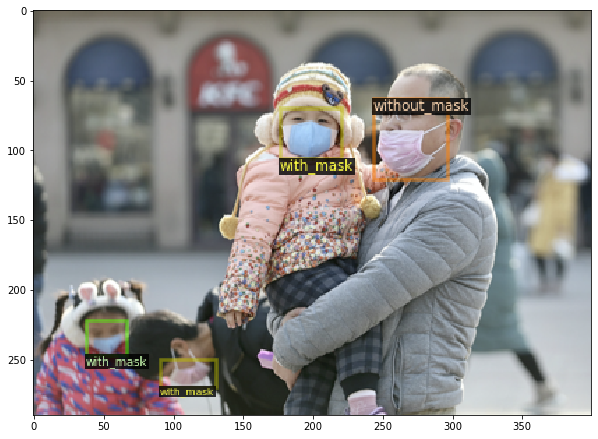

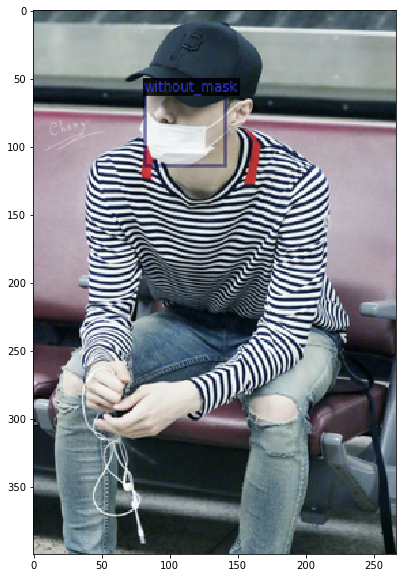

In [6]:
start = time.time()
dataset2_dicts = get_facemask_2_dicts(dataset2_dir)
print(time.time()-start)
# select two samples to verify the data loading is correct
for d in dataset2_dicts[20:22]:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=facemask_2_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image())
    plt.show()